#### 게이트가 추가된 RNN

RNN의 문제점 
- 기울기 소실 혹은 기울기 폭발이 일어남 
- Wh 행렬의 특잇값이 1보다 크면 기울기 폭발 작으면 소실이 일어날 가능성이 높다고 예측 가능함 

In [1]:
#역전파시 기울기는 MatMul 노드를 지날떄 어떻게 될까?
import numpy as np 
import matplotlib.pyplot as plt 

N=2 #미니 배치 크기
H=3 #은닉 상태 벡터의 차원 수 
T=20 #시계열 데이터의 길이 

dh=np.ones((N,H))
np.random.seed(3)
Wh=np.random.randn(H,H)

norm_list=[]
for t in range(T):
    dh=np.matmul(dh,Wh.T)
    norm=np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)
    
    


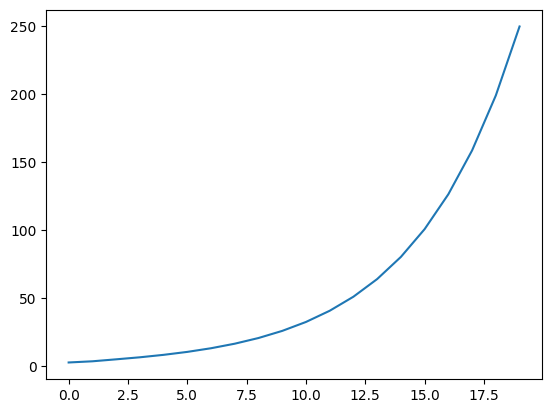

In [3]:
#기울기 폭발
plt.plot(norm_list)

In [7]:
#역전파시 기울기는 MatMul 노드를 지날떄 어떻게 될까?
import numpy as np 
import matplotlib.pyplot as plt 

N=2 #미니 배치 크기
H=3 #은닉 상태 벡터의 차원 수 
T=20 #시계열 데이터의 길이 

dh=np.ones((N,H))
np.random.seed(3)
Wh=np.random.randn(H,H)*0.5

norm_list=[]
for t in range(T):
    dh=np.matmul(dh,Wh.T)
    norm=np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)
    
    


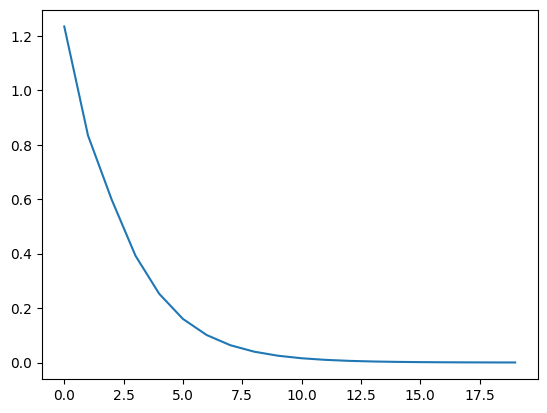

In [8]:
#기울기 소실
plt.plot(norm_list)

기울기 폭발 해결책 
- 기울기 클리핑

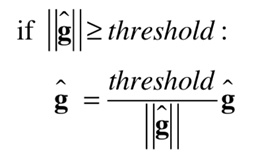 

기울기가 특정 threshold를 넘을 경우 기울기를 두 번쨰 줄의 수식과 같이 수정

In [12]:
#기울기 클리핑 구현
import numpy as np 

dW1=np.random.rand(3,3)*10
dW2=np.random.rand(3,3)*10
grads=[dW1,dW2]
max_norm=5.0

def clip_grads(grads,max_norm):
    total_norm=0
    for grad in grads:
        total_norm+=np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm+1e-6)
    if rate < 1:
        for grad in grads:
            grad*=rate

기울기 소실 해결책
- LSTM / GRU

LSTM

- output/forget/input 3개의 게이트로 구성되어있음

- 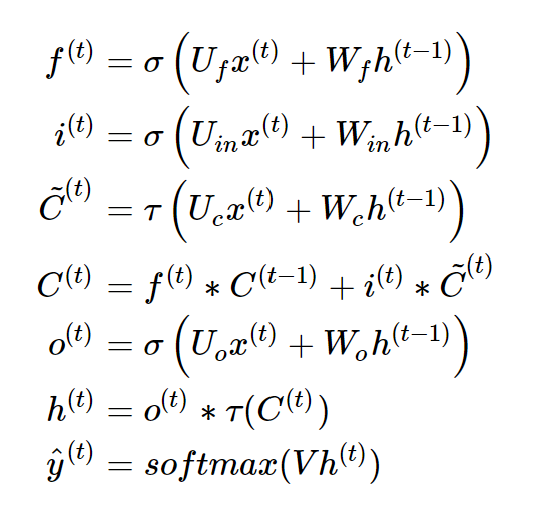

In [14]:
#LSTM 구현
from common.functions import sigmoid
class LSTM:
    def __init__(self,Wx,Wh,b):
        self.params = [Wx,Wh,b]
        #가중치와 편향에 행렬 변환과 평행이동을 결합한 형태인 '아편변환'이 적용됨 
        '''
        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache=None
        def forward(self,x,h_prev,c_prev):
            Wx,Wh,b=self.params
            N,H = h_prev.shape
            
            A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
            f = A[:, :H]
            g = A[:, H:2*H]
            i = A[:, 2*H:3*H]
            o = A[:, 3*H:]
            
            f = sigmoid(f)
            g = np.tanh(g)
            i = sigmoid(i)
            o = sigmoid(o)

            c_next = f * c_prev + g * i
            h_next = o * np.tanh(c_next)

            self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
            return h_next, c_next
            
        
        def backward(self, dh_next, dc_next):
            Wx, Wh, b = self.params
            x, h_prev, c_prev, i, f, g, o, c_next = self.cache

            tanh_c_next = np.tanh(c_next)

            ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

            dc_prev = ds * f

            di = ds * g
            df = ds * c_prev
            do = dh_next * tanh_c_next
            dg = ds * i

            di *= i * (1 - i)
            df *= f * (1 - f)
            do *= o * (1 - o)
            dg *= (1 - g ** 2)
            #slice노드에 대한 역전파 실행 과정으로 인수로 주어진 배열들을 가로로 연결함 
            dA = np.hstack((df, dg, di, do))

            dWh = np.dot(h_prev.T, dA)
            dWx = np.dot(x.T, dA)
            db = dA.sum(axis=0)

            self.grads[0][...] = dWx
            self.grads[1][...] = dWh
            self.grads[2][...] = db

            dx = np.dot(dA, Wx.T)
            dh_prev = np.dot(dA, Wh.T)

            return dx, dh_prev, dc_prev
            
